In [1]:
%matplotlib inline

# DISPERSION ANALYSIS I
Author: Jordan Guerra (for Villanova University). February 2024.

This tutorial illustrates the basic use of the package *polBpy* for performing the angular dispersion analysis for studying the magnetoturbulent state of gas using dust polarimetric observations. Parameters determined can be used for DCF calaculations.

This tutorial uses data from literature listed [here.](https://github.com/jorgueagui/polBpy/blob/9039d4af5d25c49130bf51be7fe0ce363424edcc/refs.md)

**EXAMPLE I**: This example shows how to perform the glaobal dispersion analysis for a single, masked region of gas. This analysis involves: i) calculating the autocorrelation function of the polarized flux, and measuring it width as estimation of the cloud's depnth; ii) calcualting the two-point struture function;, ii) fitting the two-point structure function with the two-scale model of Houde et. al. (2009, 2010) using a MCMC approach and determining the magnetotubrulent parameters. We reproduce here some results from Butterfiel et. al. (2024), which presents results of the Galactic center's M0.8-0.2 ring using observations of SOFIA/HAWC+.

In [2]:
import os
os.chdir(os.path.expanduser("/Users/jguerraa/Desktop/polBpy"))
from polBpy import dispersion
import numpy as np
import matplotlib.pyplot as plt

In this example we try to reproduce values from Butterfield et. al. (2024). First, we calculate the autocorrelation function using the 214 $\mu$m data from a FITS file

In [3]:
from astropy.io import fits
file = "/Users/jguerraa/Desktop/polBpy/tutorials/PolBpy_Tutorial_III_data.fits"
data = fits.open(file)
print(data.info())

Filename: /Users/jguerraa/Desktop/polBpy/tutorials/PolBpy_Tutorial_III_data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU     942   (103, 103)   float64   
  1  ERROR I       1 ImageHDU        19   (103, 103)   float64   
  2  STOKES Q      1 ImageHDU        19   (103, 103)   float64   
  3  ERROR Q       1 ImageHDU        19   (103, 103)   float64   
  4  STOKES U      1 ImageHDU        19   (103, 103)   float64   
  5  ERROR U       1 ImageHDU        19   (103, 103)   float64   
  6  IMAGE MASK    1 ImageHDU        30   (103, 103)   float64   
  7  PERCENT POL    1 ImageHDU        19   (103, 103)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        19   (103, 103)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        19   (103, 103)   float64   
 10  POL ANGLE     1 ImageHDU        19   (103, 103)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        19   (103, 103)   float64   
 12  ERROR POL ANGLE    1 ImageHDU      

First, we define the mask. This correspodn to the area in which p/p_err > 3.0 and flux < 5000 MJy/sr

Text(0.5, 1.0, 'Pixel Mask')

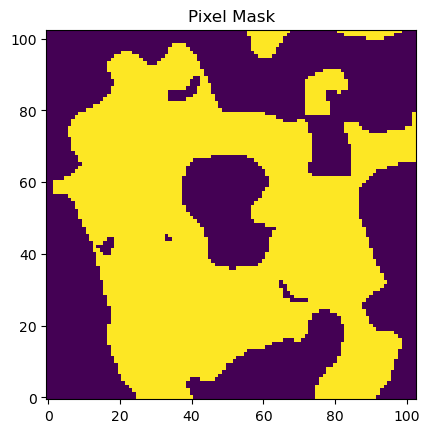

In [4]:
p_flux = data['DEBIASED POL FLUX'].data # 
p_flux_err = data['ERROR POL FLUX'].data #
stokes_I = data['STOKES I'].data #
pixel_size = data[0].header['CDELT2']*3600 #in arcsec
beam_area=(float(pixel_size)/3600*np.pi/180)**2 #in sr
stokes_I /= beam_area 
stokes_I /= 1E+6 # In MJy/sr
#
m = np.where((p_flux/p_flux_err > 3.0) & (stokes_I > 5000.0))
pixel_mask = np.full_like(stokes_I,0.0)
pixel_mask[m] = 1.0
plt.imshow(pixel_mask,origin='lower')
plt.title('Pixel Mask')

We can also, define a region mask, in order to focus on a region of interest. We want to inlcude data only up to ~ 9 pc from the center of the ring,

Filename: /Users/jguerraa/Desktop/polBpy/tutorials/PolBpy_Tutorial_III_mask.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU     940   ()      
  1  MASK          1 ImageHDU         8   (103, 103)   float64   
None


Text(0.5, 1.0, 'Region Mask')

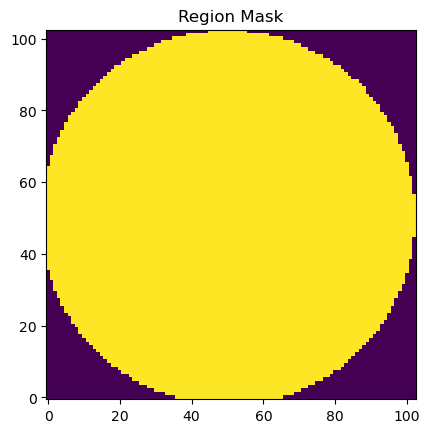

In [5]:
file = "/Users/jguerraa/Desktop/polBpy/tutorials/PolBpy_Tutorial_III_mask.fits"
data_mask = fits.open(file)
print(data_mask.info())
region_mask = data_mask[1].data
plt.imshow(region_mask,origin='lower')
plt.title('Region Mask')

Now we calculate the total mask = pixel_mask x region_mask,

Text(0.5, 1.0, 'Total Mask')

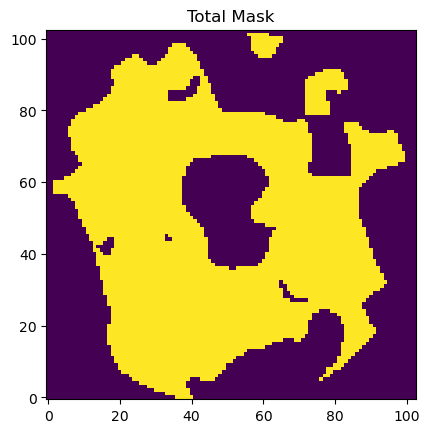

In [6]:
mask = pixel_mask*region_mask
plt.imshow(mask,origin='lower')
plt.title('Total Mask')

When calling the autocorrelation function, we ha ve few options. Firts, in order to obtain the cloud's depth in physical unit, we need to express the pixel size in arcseconds. If not specified, the resulting $\Delta^{\prime}$ is in pixel units. Second, if plots=True is set, the routine display the plot of resulting autocorrelation function, for visual inspection. Third, if hwhm=True is set, the result is the half-width, half-max value of the autocorreltion function. 

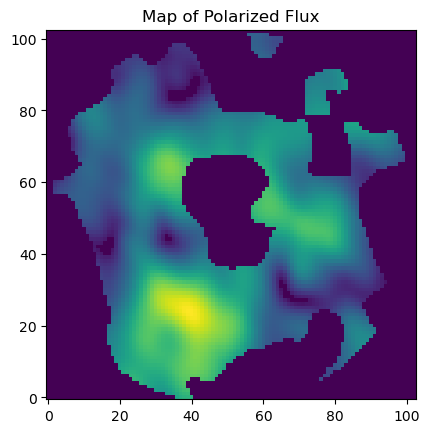

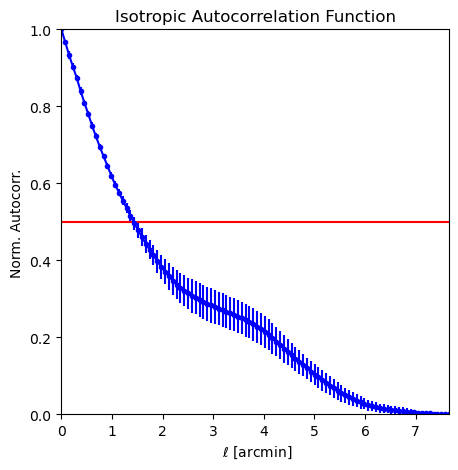

In [7]:
res = dispersion.autocorrelation(p_flux,p_flux_err,pixsize=pixel_size,mask=mask,plots=True,hwhm=True)

The result is the $\Delta^{\prime}$ in the input units

In [8]:
print("Delta' = %2.2f +/- %2.2f [arcmin]"%(res[0],res[1]))

Delta' = 1.43 +/- 0.06 [arcmin]


If you want the autocorrelation values for your own plotting and further analysis, run the autocorrelation function with hwhm=False,

In [9]:
res = dispersion.autocorrelation(p_flux,p_flux_err,pixsize=pixel_size,mask=mask,plots=False,hwhm=False)

Text(0, 0.5, 'Norm. Autocorr.')

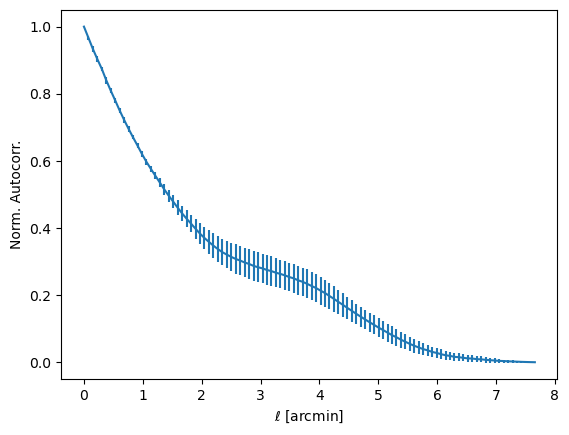

In [10]:
lvals = res[2]/60. # in arcmin
autocorr = res[0] # 
autocorr_err = res[1]
plt.errorbar(lvals,autocorr,yerr=autocorr_err)
plt.xlabel(r'$\ell$ [arcmin]')
plt.ylabel('Norm. Autocorr.')

**EXAMPLE II**: This example shows how to calculate statistical (median, 5th, 95th) values of $B_{POS}$
  using the large-scale and shear flow DCF approximation. We reproduce some results from Guerra et. al. (2023), which presents results of the CND using observations of SOFIA/HAWC+.
In this case, we need the information of the large-scale flow...

In [11]:
ls_flow = data['POS_VEL'].data # km/s
ls_flow_err = data['POS_VEL_ERROR'].data # km/s

KeyError: "Extension 'POS_VEL' not found."

First, calculate the DCF using the large scale modification,

In [ ]:
bpos = DCF.dcf_range(col_den,vel_disp,ang_disp,m_flow=ls_flow,dcftype='ls-flow',rho=False,m_cdepth=cloud_depth,m_uden=ucol_den,m_uvel=uvel_disp,m_udisp=uang_disp,m_ucdepth=ucloud_depth,m_uflow=ls_flow_err)

In [ ]:
print("Median Bpos = %2.2f +/- %2.2f [mG]"%(bpos[1][0]/1000.,bpos[1][1]/1000.))

In [ ]:
print("5-percentile Bpos = %2.2f +/- %2.2f [mG]"%(bpos[0][0]/1000.,bpos[0][1]/1000.))

In [ ]:
print("95-percentile Bpos = %2.2f +/- %2.2f [mG]"%(bpos[2][0]/1000.,bpos[2][1]/1000.))

Next, to use the shear flow approximation, we need the Laplacian of the POS velocity field

In [ ]:
ls_flow_lap = data['POS_VEL_LAP'].data # km/s/pix/pix

In order to give the laplacian physical units of km/s, we need to choose a scale. we write c = cloud_depth/pixsize and normilized the laplacian as

In [ ]:
pixsize = 1.50E+17
c = cloud_depth/pixsize
ls_flow_lap *= c**2
print(c)

In [ ]:
bpos = DCF.dcf_range(col_den,vel_disp,ang_disp,m_flow=ls_flow,m_flow_lap=ls_flow_lap,dcftype='shear-flow',rho=False,m_cdepth=cloud_depth,m_uden=ucol_den,m_uvel=uvel_disp,m_udisp=uang_disp,m_ucdepth=ucloud_depth,m_uflow=ls_flow_err)

In [ ]:
print("Median Bpos = %2.2f +/- %2.2f [mG]"%(bpos[1][0]/1000.,bpos[1][1]/1000.))

In [ ]:
print("5-percentile Bpos = %2.2f +/- %2.2f [mG]"%(bpos[0][0]/1000.,bpos[0][1]/1000.))

In [ ]:
print("95-percentile Bpos = %2.2f +/- %2.2f [mG]"%(bpos[2][0]/1000.,bpos[2][1]/1000.))

In [ ]:
np.nanmin(ls_flow_lap)

In [ ]:
np.nanmax(ls_flow_lap)